## Forecasting Inverters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [2]:
df = pd.read_csv('../data/interim/filled_for_forecasting.csv', index_col = 0, parse_dates = True)

In [3]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

### Convert all 15-min data to hourly

In [4]:
# First calcluate difference between two inverters
df['Difference'] = df['AE 500kW 1, AC Power Kilowatts'] - df['AE 500kW 2, AC Power Kilowatts']

# Now get hourly energy in KWH
energy_hourly = df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].resample('H').mean()
energy_hourly.columns=['AE 500kW 1, KWH','AE 500kW 2, KWH']

energy_hourly['Max Module Temp'] = df['RECx31 Weather Station, Module Temp Degrees Celsius'].resample('H').max()
energy_hourly['Max Ambient Temp'] = df['RECx31 Weather Station, Ambient Temp Degrees Celsius'].resample('H').max()
energy_hourly['Max Difference'] = df['Difference'].resample('H').max()

# Now calculate the difference between the two inverters
energy_hourly['Difference'] = energy_hourly['AE 500kW 1, KWH'] - energy_hourly['AE 500kW 2, KWH']

### Resample to Daily Data and Fill Missing Data

We're going to resample to daily data, taking the max of the hourly temps (intuitively reasoning that max temp might be the most important feature of temperature), and summing the rest.  

In [83]:
energy_daily = \
    energy_hourly[['AE 500kW 1, KWH', 'AE 500kW 2, KWH', 'Difference']].resample('D').sum()
energy_daily[['Max Module Temp','Max Ambient Temp','Max Difference']] = \
    energy_hourly[['Max Module Temp','Max Ambient Temp','Max Difference']].resample('D').max()

In [84]:
energy_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1919 entries, 2015-10-01 to 2020-12-31
Freq: D
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AE 500kW 1, KWH   1919 non-null   float64
 1   AE 500kW 2, KWH   1919 non-null   float64
 2   Difference        1919 non-null   float64
 3   Max Module Temp   1919 non-null   float64
 4   Max Ambient Temp  1919 non-null   float64
 5   Max Difference    1875 non-null   float64
dtypes: float64(6)
memory usage: 104.9 KB


In [85]:
energy_daily.fillna(0, inplace=True)

### Feature Engineering

We're going to add columns to our dataframe based on the historical data.  

In [86]:
# # Now let's have Inverter1 only see its issues and Inverter2 only see its
energy_daily['Diff_Inv1'] = energy_daily.apply(lambda x: 0 if x['Difference']>0 else -x['Difference'], axis=1)
energy_daily['Diff_Inv2'] = energy_daily.apply(lambda x: 0 if x['Difference']<0 else x['Difference'], axis=1)

energy_daily['Max_Diff_Inv1'] = energy_daily.apply(lambda x: 0 if x['Max Difference']>0 else -x['Max Difference'], axis=1)
energy_daily['Max_Diff_Inv2'] = energy_daily.apply(lambda x: 0 if x['Max Difference']<0 else x['Max Difference'], axis=1)

In [87]:
# Set up our dataframes for forecasting
Inverter1 = pd.DataFrame(energy_daily['AE 500kW 1, KWH'].copy(), columns=['AE 500kW 1, KWH'])
Inverter2 = pd.DataFrame(energy_daily['AE 500kW 2, KWH'].copy(), columns=['AE 500kW 2, KWH'])

In [88]:
# Set up our exogeneous variables. 
# These will contain information shifted by 1
#Temperatures 
Inverter1['MMT'] = energy_daily['Max Module Temp'].shift(1)
Inverter1['MAT'] = energy_daily['Max Ambient Temp'].shift(1)
Inverter2['MMT'] = energy_daily['Max Module Temp'].shift(1)
Inverter2['MAT'] = energy_daily['Max Ambient Temp'].shift(1)

# Difference between two inverters
Inverter1['Diff_Inv1'] = energy_daily['Diff_Inv1'].shift(1)
Inverter2['Diff_Inv2'] = energy_daily['Diff_Inv2'].shift(1)

# Difference between two inverters
Inverter1['Max_Diff_Inv1'] = energy_daily['Max_Diff_Inv1'].shift(1)
Inverter2['Max_Diff_Inv2'] = energy_daily['Max_Diff_Inv2'].shift(1)

In [89]:
# Drop null values from doing the shifts
Inverter1.dropna(inplace=True)
Inverter2.dropna(inplace=True)

### Forecasting

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


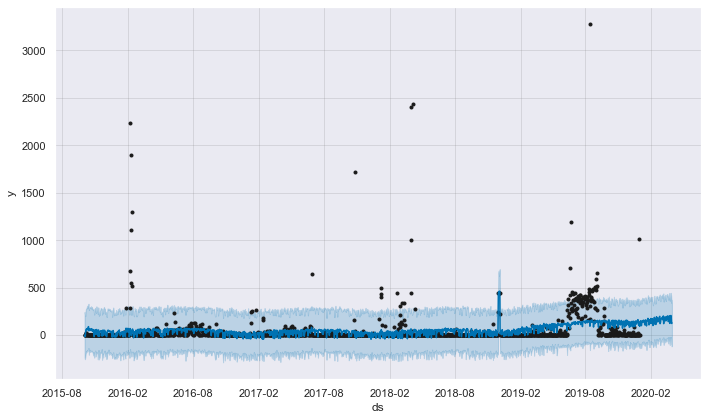

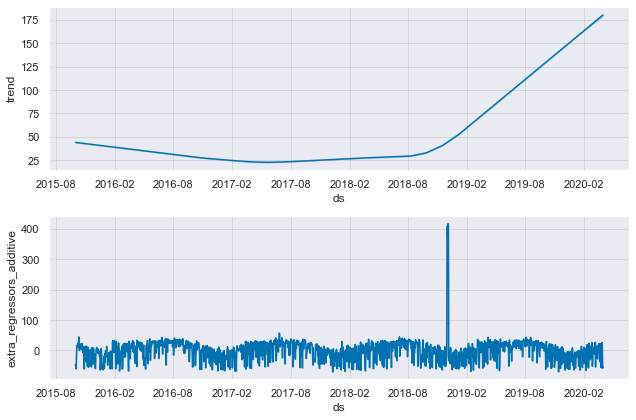

In [102]:
Inverter1['y'] = Inverter1['Diff_Inv1']
Inverter1['ds'] = Inverter1.index

prophet = Prophet(weekly_seasonality=False, yearly_seasonality=False)
prophet.add_regressor('MMT')
prophet.add_regressor('MAT')
prophet.add_regressor('Max_Diff_Inv1')
prophet.fit(Inverter1.loc[:'2019'])
future = prophet.make_future_dataframe(periods=90, freq='D')
future.set_index('ds',inplace=True)
future['MMT'] = Inverter1['MMT']
future['MAT'] = Inverter1['MAT']
future['Max_Diff_Inv1'] = Inverter1['Max_Diff_Inv1']
future.reset_index(inplace=True)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
fig2 = prophet.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


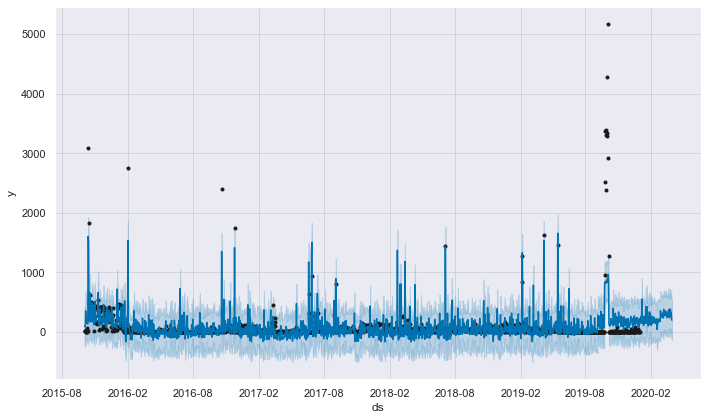

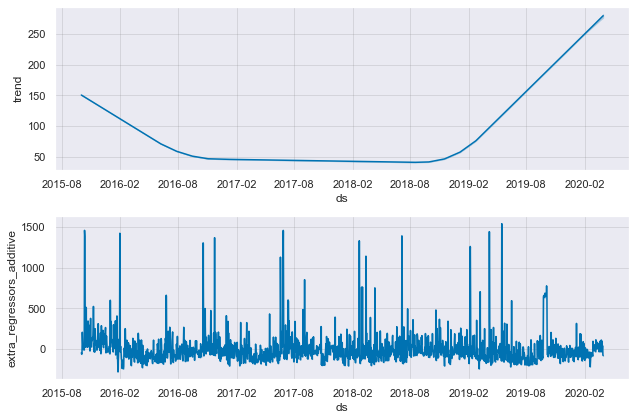

In [100]:
Inverter2['y'] = Inverter2['Diff_Inv2']
Inverter2['ds'] = Inverter2.index

prophet = Prophet(weekly_seasonality=False, yearly_seasonality=False)
prophet.add_regressor('MMT')
prophet.add_regressor('MAT')
prophet.add_regressor('Max_Diff_Inv2')
prophet.fit(Inverter2.loc[:'2019'])
future = prophet.make_future_dataframe(periods=90, freq='D')
future.set_index('ds',inplace=True)
future['MMT'] = Inverter2['MMT']
future['MAT'] = Inverter2['MAT']
future['Max_Diff_Inv2'] = Inverter2['Max_Diff_Inv2']
future.reset_index(inplace=True)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
fig2 = prophet.plot_components(forecast)